In this notebook, I want to compute the uncertainty of the phonon dispersion curves from the bootstrap ensembles.

In [1]:
from pathlib import Path
import pickle
import json
from datetime import datetime
from tqdm import tqdm
import sys
from multiprocessing import Pool

from ase.build import bulk
from ase.calculators.kim import KIM
from ase.phonons import Phonons
from ase.visualize import view

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use("default")

WORK_DIR = Path().absolute()
sys.path.append(str(WORK_DIR.parent))

In [2]:
# Read setting file
ROOT_DIR = WORK_DIR.parent
with open(ROOT_DIR / "settings.json", "r") as f:
    settings = json.load(f)
partition = settings["partition"]
RES_DIR = WORK_DIR / "results" / f"{partition}_partition"
if not RES_DIR.exists():
    RES_DIR.mkdir(parents=True)

In [3]:
# Diamond bulk
a0 = 3.56
atoms = bulk("C", "diamond", a0)
# view(atoms.repeat((2, 2, 2)))

In [4]:
def phonon_wrapper(set_idx):
    sample_dir = RES_DIR / f"{set_idx:03d}"
    modelname = f"DUNN_C_fimbayes_{set_idx:03d}"

    # Phonon calculator
    calc = KIM(modelname)
    ph = Phonons(
        atoms, calc, supercell=(7, 7, 7), delta=0.1, name=sample_dir / "phonon_diamond"
    )
    ph.run()

    # Read forces and assemble the dynamical matrix
    ph.read(acoustic=True)
    # ph.clean()

    path = atoms.cell.bandpath("GXUGL", npoints=100)
    bs = ph.get_band_structure(path)
    return bs.energies


with Pool(25) as p:
    energies = np.array(list(p.map(phonon_wrapper, range(100))))
    
energies = energies[:, 0]

WARNING, 2 imaginary frequencies at q = ( 0.00,  0.00,  0.00) ; (omega_q = 6.912e-08*i)
WARNING, 2 imaginary frequencies at q = ( 0.00,  0.00,  0.00) ; (omega_q = 6.912e-08*i)
WARNING, 1 imaginary frequencies at q = ( 0.02,  0.00,  0.02) ; (omega_q = 3.563e-01*i)
WARNING, 1 imaginary frequencies at q = ( 0.03,  0.00,  0.03) ; (omega_q = 7.049e-01*i)
WARNING, 1 imaginary frequencies at q = ( 0.05,  0.00,  0.05) ; (omega_q = 1.038e+00*i)
WARNING, 1 imaginary frequencies at q = ( 0.07,  0.00,  0.07) ; (omega_q = 1.350e+00*i)
WARNING, 1 imaginary frequencies at q = ( 0.09,  0.00,  0.09) ; (omega_q = 1.633e+00*i)
WARNING, 1 imaginary frequencies at q = ( 0.10,  0.00,  0.10) ; (omega_q = 1.882e+00*i)
WARNING, 1 imaginary frequencies at q = ( 0.12,  0.00,  0.12) ; (omega_q = 2.092e+00*i)
WARNING, 1 imaginary frequencies at q = ( 0.14,  0.00,  0.14) ; (omega_q = 2.258e+00*i)
WARNING, 1 imaginary frequencies at q = ( 0.16,  0.00,  0.16) ; (omega_q = 2.379e+00*i)
WARNING, 1 imaginary frequencies

WARNING, 1 imaginary frequencies at q = ( 0.09,  0.04,  0.09) ; (omega_q = 8.668e-01*i)
WARNING, 1 imaginary frequencies at q = ( 0.08,  0.03,  0.08) ; (omega_q = 7.252e-01*i)
WARNING, 2 imaginary frequencies at q = ( 0.06,  0.02,  0.06) ; (omega_q = 5.631e-01*i)
WARNING, 2 imaginary frequencies at q = ( 0.04,  0.02,  0.04) ; (omega_q = 3.849e-01*i)
WARNING, 2 imaginary frequencies at q = ( 0.02,  0.01,  0.02) ; (omega_q = 1.953e-01*i)
WARNING, 3 imaginary frequencies at q = ( 0.02,  0.02,  0.02) ; (omega_q = 1.875e-01*i)
WARNING, 3 imaginary frequencies at q = ( 0.04,  0.04,  0.04) ; (omega_q = 3.696e-01*i)
WARNING, 3 imaginary frequencies at q = ( 0.06,  0.06,  0.06) ; (omega_q = 5.409e-01*i)
WARNING, 3 imaginary frequencies at q = ( 0.07,  0.07,  0.07) ; (omega_q = 6.969e-01*i)
WARNING, 1 imaginary frequencies at q = ( 0.09,  0.09,  0.09) ; (omega_q = 8.332e-01*i)
WARNING, 1 imaginary frequencies at q = ( 0.11,  0.11,  0.11) ; (omega_q = 9.463e-01*i)
WARNING, 1 imaginary frequencies

WARNING, 1 imaginary frequencies at q = ( 0.05,  0.00,  0.05) ; (omega_q = 3.183e-01*i)
WARNING, 1 imaginary frequencies at q = ( 0.07,  0.00,  0.07) ; (omega_q = 4.201e-01*i)
WARNING, 1 imaginary frequencies at q = ( 0.09,  0.00,  0.09) ; (omega_q = 5.173e-01*i)
WARNING, 1 imaginary frequencies at q = ( 0.10,  0.00,  0.10) ; (omega_q = 6.074e-01*i)
WARNING, 1 imaginary frequencies at q = ( 0.12,  0.00,  0.12) ; (omega_q = 6.877e-01*i)
WARNING, 1 imaginary frequencies at q = ( 0.14,  0.00,  0.14) ; (omega_q = 7.547e-01*i)
WARNING, 1 imaginary frequencies at q = ( 0.16,  0.00,  0.16) ; (omega_q = 8.045e-01*i)
WARNING, 1 imaginary frequencies at q = ( 0.17,  0.00,  0.17) ; (omega_q = 8.324e-01*i)
WARNING, 1 imaginary frequencies at q = ( 0.19,  0.00,  0.19) ; (omega_q = 8.332e-01*i)
WARNING, 1 imaginary frequencies at q = ( 0.21,  0.00,  0.21) ; (omega_q = 7.995e-01*i)
WARNING, 1 imaginary frequencies at q = ( 0.22,  0.00,  0.22) ; (omega_q = 7.202e-01*i)
WARNING, 1 imaginary frequencies

WARNING, 1 imaginary frequencies at q = ( 0.06,  0.06,  0.06) ; (omega_q = 3.298e-01*i)
WARNING, 1 imaginary frequencies at q = ( 0.07,  0.07,  0.07) ; (omega_q = 4.306e-01*i)
WARNING, 1 imaginary frequencies at q = ( 0.09,  0.09,  0.09) ; (omega_q = 5.235e-01*i)
WARNING, 1 imaginary frequencies at q = ( 0.11,  0.11,  0.11) ; (omega_q = 6.063e-01*i)
WARNING, 1 imaginary frequencies at q = ( 0.13,  0.13,  0.13) ; (omega_q = 6.769e-01*i)
WARNING, 1 imaginary frequencies at q = ( 0.15,  0.15,  0.15) ; (omega_q = 7.329e-01*i)
WARNING, 3 imaginary frequencies at q = ( 0.00,  0.00,  0.00) ; (omega_q = 7.552e-08*i)WARNING, 1 imaginary frequencies at q = ( 0.17,  0.17,  0.17) ; (omega_q = 7.717e-01*i)

WARNING, 1 imaginary frequencies at q = ( 0.19,  0.19,  0.19) ; (omega_q = 7.906e-01*i)
WARNING, 1 imaginary frequencies at q = ( 0.20,  0.20,  0.20) ; (omega_q = 7.861e-01*i)
WARNING, 1 imaginary frequencies at q = ( 0.22,  0.22,  0.22) ; (omega_q = 7.540e-01*i)
WARNING, 1 imaginary frequencies

WARNING, 2 imaginary frequencies at q = ( 0.00,  0.00,  0.00) ; (omega_q = 5.497e-08*i)
WARNING, 4 imaginary frequencies at q = ( 0.00,  0.00,  0.00) ; (omega_q = 3.150e-01*i)
WARNING, 5 imaginary frequencies at q = ( 0.02,  0.00,  0.02) ; (omega_q = 4.408e-01*i)
WARNING, 5 imaginary frequencies at q = ( 0.03,  0.00,  0.03) ; (omega_q = 8.642e-01*i)
WARNING, 4 imaginary frequencies at q = ( 0.05,  0.00,  0.05) ; (omega_q = 1.267e+00*i)
WARNING, 4 imaginary frequencies at q = ( 0.07,  0.00,  0.07) ; (omega_q = 1.638e+00*i)
WARNING, 4 imaginary frequencies at q = ( 0.09,  0.00,  0.09) ; (omega_q = 1.968e+00*i)
WARNING, 3 imaginary frequencies at q = ( 0.10,  0.00,  0.10) ; (omega_q = 2.248e+00*i)
WARNING, 3 imaginary frequencies at q = ( 0.12,  0.00,  0.12) ; (omega_q = 2.474e+00*i)
WARNING, 3 imaginary frequencies at q = ( 0.14,  0.00,  0.14) ; (omega_q = 2.641e+00*i)
WARNING, 3 imaginary frequencies at q = ( 0.16,  0.00,  0.16) ; (omega_q = 2.746e+00*i)
WARNING, 3 imaginary frequencies

WARNING, 1 imaginary frequencies at q = ( 0.09,  0.04,  0.09) ; (omega_q = 2.056e-01*i)
WARNING, 1 imaginary frequencies at q = ( 0.08,  0.03,  0.08) ; (omega_q = 1.983e-01*i)
WARNING, 1 imaginary frequencies at q = ( 0.06,  0.02,  0.06) ; (omega_q = 1.679e-01*i)
WARNING, 1 imaginary frequencies at q = ( 0.04,  0.02,  0.04) ; (omega_q = 1.210e-01*i)
WARNING, 2 imaginary frequencies at q = ( 0.02,  0.01,  0.02) ; (omega_q = 6.322e-02*i)
WARNING, 3 imaginary frequencies at q = ( 0.00,  0.00,  0.00) ; (omega_q = 7.371e-08*i)
WARNING, 3 imaginary frequencies at q = ( 0.02,  0.02,  0.02) ; (omega_q = 4.400e-02*i)
WARNING, 3 imaginary frequencies at q = ( 0.04,  0.04,  0.04) ; (omega_q = 7.806e-02*i)
WARNING, 3 imaginary frequencies at q = ( 0.06,  0.06,  0.06) ; (omega_q = 1.023e-01*i)
WARNING, 3 imaginary frequencies at q = ( 0.07,  0.07,  0.07) ; (omega_q = 1.054e-01*i)
WARNING, 1 imaginary frequencies at q = ( 0.09,  0.09,  0.09) ; (omega_q = 6.115e-02*i)
WARNING, 1 imaginary frequencies

WARNING, 1 imaginary frequencies at q = ( 0.40,  0.16,  0.40) ; (omega_q = 2.273e-01*i)
WARNING, 1 imaginary frequencies at q = ( 0.38,  0.15,  0.38) ; (omega_q = 7.823e-01*i)
WARNING, 1 imaginary frequencies at q = ( 0.36,  0.14,  0.36) ; (omega_q = 1.119e+00*i)
WARNING, 1 imaginary frequencies at q = ( 0.34,  0.14,  0.34) ; (omega_q = 1.390e+00*i)
WARNING, 1 imaginary frequencies at q = ( 0.32,  0.13,  0.32) ; (omega_q = 1.620e+00*i)
WARNING, 1 imaginary frequencies at q = ( 0.30,  0.12,  0.30) ; (omega_q = 1.813e+00*i)
WARNING, 1 imaginary frequencies at q = ( 0.28,  0.11,  0.28) ; (omega_q = 1.973e+00*i)
WARNING, 1 imaginary frequencies at q = ( 0.27,  0.11,  0.27) ; (omega_q = 2.097e+00*i)
WARNING, 1 imaginary frequencies at q = ( 0.25,  0.10,  0.25) ; (omega_q = 2.186e+00*i)
WARNING, 1 imaginary frequencies at q = ( 0.23,  0.09,  0.23) ; (omega_q = 2.237e+00*i)
WARNING, 1 imaginary frequencies at q = ( 0.21,  0.08,  0.21) ; (omega_q = 2.248e+00*i)
WARNING, 1 imaginary frequencies

WARNING, 3 imaginary frequencies at q = ( 0.08,  0.03,  0.08) ; (omega_q = 8.938e-01*i)
WARNING, 3 imaginary frequencies at q = ( 0.06,  0.02,  0.06) ; (omega_q = 6.908e-01*i)
WARNING, 3 imaginary frequencies at q = ( 0.04,  0.02,  0.04) ; (omega_q = 4.706e-01*i)
WARNING, 3 imaginary frequencies at q = ( 0.02,  0.01,  0.02) ; (omega_q = 2.384e-01*i)
WARNING, 1 imaginary frequencies at q = ( 0.00,  0.00,  0.00) ; (omega_q = 4.836e-08*i)
WARNING, 3 imaginary frequencies at q = ( 0.02,  0.02,  0.02) ; (omega_q = 2.342e-01*i)
WARNING, 3 imaginary frequencies at q = ( 0.04,  0.04,  0.04) ; (omega_q = 4.627e-01*i)
WARNING, 3 imaginary frequencies at q = ( 0.06,  0.06,  0.06) ; (omega_q = 6.798e-01*i)
WARNING, 3 imaginary frequencies at q = ( 0.07,  0.07,  0.07) ; (omega_q = 8.806e-01*i)
WARNING, 3 imaginary frequencies at q = ( 0.09,  0.09,  0.09) ; (omega_q = 1.061e+00*i)
WARNING, 3 imaginary frequencies at q = ( 0.11,  0.11,  0.11) ; (omega_q = 1.217e+00*i)
WARNING, 1 imaginary frequencies

WARNING, 1 imaginary frequencies at q = ( 0.39,  0.39,  0.39) ; (omega_q = 1.139e+00*i)
WARNING, 1 imaginary frequencies at q = ( 0.41,  0.41,  0.41) ; (omega_q = 6.752e-01*i)
WARNING, 2 imaginary frequencies at q = ( 0.00,  0.00,  0.00) ; (omega_q = 5.150e-08*i)
WARNING, 2 imaginary frequencies at q = ( 0.00,  0.00,  0.00) ; (omega_q = 5.150e-08*i)
WARNING, 1 imaginary frequencies at q = ( 0.00,  0.00,  0.00) ; (omega_q = 7.547e-08*i)
WARNING, 1 imaginary frequencies at q = ( 0.02,  0.00,  0.02) ; (omega_q = 2.478e-01*i)
WARNING, 1 imaginary frequencies at q = ( 0.03,  0.00,  0.03) ; (omega_q = 4.888e-01*i)
WARNING, 1 imaginary frequencies at q = ( 0.05,  0.00,  0.05) ; (omega_q = 7.165e-01*i)
WARNING, 1 imaginary frequencies at q = ( 0.07,  0.00,  0.07) ; (omega_q = 9.248e-01*i)
WARNING, 1 imaginary frequencies at q = ( 0.09,  0.00,  0.09) ; (omega_q = 1.108e+00*i)
WARNING, 1 imaginary frequencies at q = ( 0.10,  0.00,  0.10) ; (omega_q = 1.262e+00*i)
WARNING, 1 imaginary frequencies

WARNING, 1 imaginary frequencies at q = ( 0.17,  0.07,  0.17) ; (omega_q = 1.124e+00*i)
WARNING, 1 imaginary frequencies at q = ( 0.15,  0.06,  0.15) ; (omega_q = 1.073e+00*i)
WARNING, 1 imaginary frequencies at q = ( 0.13,  0.05,  0.13) ; (omega_q = 9.986e-01*i)
WARNING, 1 imaginary frequencies at q = ( 0.11,  0.05,  0.11) ; (omega_q = 9.021e-01*i)
WARNING, 1 imaginary frequencies at q = ( 0.09,  0.04,  0.09) ; (omega_q = 7.856e-01*i)
WARNING, 1 imaginary frequencies at q = ( 0.08,  0.03,  0.08) ; (omega_q = 6.514e-01*i)
WARNING, 1 imaginary frequencies at q = ( 0.06,  0.02,  0.06) ; (omega_q = 5.023e-01*i)
WARNING, 1 imaginary frequencies at q = ( 0.04,  0.02,  0.04) ; (omega_q = 3.416e-01*i)
WARNING, 1 imaginary frequencies at q = ( 0.02,  0.01,  0.02) ; (omega_q = 1.728e-01*i)
WARNING, 3 imaginary frequencies at q = ( 0.00,  0.00,  0.00) ; (omega_q = 4.700e-08*i)
WARNING, 3 imaginary frequencies at q = ( 0.02,  0.02,  0.02) ; (omega_q = 1.678e-01*i)
WARNING, 3 imaginary frequencies

WARNING, 1 imaginary frequencies at q = ( 0.00,  0.00,  0.00) ; (omega_q = 4.393e-08*i)
WARNING, 2 imaginary frequencies at q = ( 0.00,  0.00,  0.00) ; (omega_q = 6.699e-08*i)
WARNING, 2 imaginary frequencies at q = ( 0.02,  0.00,  0.02) ; (omega_q = 4.903e-01*i)
WARNING, 2 imaginary frequencies at q = ( 0.03,  0.00,  0.03) ; (omega_q = 9.684e-01*i)
WARNING, 2 imaginary frequencies at q = ( 0.05,  0.00,  0.05) ; (omega_q = 1.423e+00*i)
WARNING, 2 imaginary frequencies at q = ( 0.07,  0.00,  0.07) ; (omega_q = 1.842e+00*i)
WARNING, 2 imaginary frequencies at q = ( 0.09,  0.00,  0.09) ; (omega_q = 2.217e+00*i)
WARNING, 1 imaginary frequencies at q = ( 0.10,  0.00,  0.10) ; (omega_q = 2.539e+00*i)
WARNING, 1 imaginary frequencies at q = ( 0.12,  0.00,  0.12) ; (omega_q = 2.801e+00*i)
WARNING, 1 imaginary frequencies at q = ( 0.14,  0.00,  0.14) ; (omega_q = 2.999e+00*i)
WARNING, 1 imaginary frequencies at q = ( 0.16,  0.00,  0.16) ; (omega_q = 3.130e+00*i)
WARNING, 1 imaginary frequencies

WARNING, 1 imaginary frequencies at q = ( 0.25,  0.10,  0.25) ; (omega_q = 1.256e+00*i)
WARNING, 1 imaginary frequencies at q = ( 0.23,  0.09,  0.23) ; (omega_q = 1.319e+00*i)
WARNING, 1 imaginary frequencies at q = ( 0.21,  0.08,  0.21) ; (omega_q = 1.350e+00*i)
WARNING, 1 imaginary frequencies at q = ( 0.19,  0.08,  0.19) ; (omega_q = 1.351e+00*i)
WARNING, 1 imaginary frequencies at q = ( 0.17,  0.07,  0.17) ; (omega_q = 1.323e+00*i)
WARNING, 1 imaginary frequencies at q = ( 0.15,  0.06,  0.15) ; (omega_q = 1.266e+00*i)
WARNING, 1 imaginary frequencies at q = ( 0.13,  0.05,  0.13) ; (omega_q = 1.181e+00*i)
WARNING, 1 imaginary frequencies at q = ( 0.11,  0.05,  0.11) ; (omega_q = 1.070e+00*i)
WARNING, 1 imaginary frequencies at q = ( 0.09,  0.04,  0.09) ; (omega_q = 9.343e-01*i)
WARNING, 1 imaginary frequencies at q = ( 0.08,  0.03,  0.08) ; (omega_q = 7.766e-01*i)
WARNING, 1 imaginary frequencies at q = ( 0.06,  0.02,  0.06) ; (omega_q = 6.001e-01*i)
WARNING, 2 imaginary frequencies

WARNING, 1 imaginary frequencies at q = ( 0.09,  0.09,  0.09) ; (omega_q = 1.036e+00*i)
WARNING, 1 imaginary frequencies at q = ( 0.11,  0.11,  0.11) ; (omega_q = 1.186e+00*i)
WARNING, 1 imaginary frequencies at q = ( 0.13,  0.13,  0.13) ; (omega_q = 1.310e+00*i)
WARNING, 1 imaginary frequencies at q = ( 0.15,  0.15,  0.15) ; (omega_q = 1.403e+00*i)
WARNING, 1 imaginary frequencies at q = ( 0.17,  0.17,  0.17) ; (omega_q = 1.463e+00*i)
WARNING, 1 imaginary frequencies at q = ( 0.19,  0.19,  0.19) ; (omega_q = 1.489e+00*i)
WARNING, 1 imaginary frequencies at q = ( 0.20,  0.20,  0.20) ; (omega_q = 1.479e+00*i)
WARNING, 1 imaginary frequencies at q = ( 0.22,  0.22,  0.22) ; (omega_q = 1.429e+00*i)
WARNING, 1 imaginary frequencies at q = ( 0.24,  0.24,  0.24) ; (omega_q = 1.336e+00*i)
WARNING, 1 imaginary frequencies at q = ( 0.26,  0.26,  0.26) ; (omega_q = 1.194e+00*i)
WARNING, 1 imaginary frequencies at q = ( 0.28,  0.28,  0.28) ; (omega_q = 9.874e-01*i)
WARNING, 1 imaginary frequencies

In [5]:
# Get band structure
# Phonon calculator
calc = KIM("DUNN_C_randinit_000")
ph = Phonons(
    atoms, calc, supercell=(7, 7, 7), delta=0.1, name=RES_DIR / "000" / "phonon_diamond"
)
ph.run()
ph.read(acoustic=True)
path = atoms.cell.bandpath("GXUGL", npoints=100)
bs = ph.get_band_structure(path)

WARNING, 1 imaginary frequencies at q = ( 0.02,  0.00,  0.02) ; (omega_q = 1.071e-01*i)
WARNING, 1 imaginary frequencies at q = ( 0.03,  0.00,  0.03) ; (omega_q = 2.135e-01*i)
WARNING, 1 imaginary frequencies at q = ( 0.05,  0.00,  0.05) ; (omega_q = 3.183e-01*i)
WARNING, 1 imaginary frequencies at q = ( 0.07,  0.00,  0.07) ; (omega_q = 4.201e-01*i)
WARNING, 1 imaginary frequencies at q = ( 0.09,  0.00,  0.09) ; (omega_q = 5.173e-01*i)
WARNING, 1 imaginary frequencies at q = ( 0.10,  0.00,  0.10) ; (omega_q = 6.074e-01*i)
WARNING, 1 imaginary frequencies at q = ( 0.12,  0.00,  0.12) ; (omega_q = 6.877e-01*i)
WARNING, 1 imaginary frequencies at q = ( 0.14,  0.00,  0.14) ; (omega_q = 7.547e-01*i)
WARNING, 1 imaginary frequencies at q = ( 0.16,  0.00,  0.16) ; (omega_q = 8.045e-01*i)
WARNING, 1 imaginary frequencies at q = ( 0.17,  0.00,  0.17) ; (omega_q = 8.324e-01*i)
WARNING, 1 imaginary frequencies at q = ( 0.19,  0.00,  0.19) ; (omega_q = 8.332e-01*i)
WARNING, 1 imaginary frequencies

In [6]:
# Convert to THz
conversion = 4.136e-3 # 1 Thz = 4.136 meV
energies /= conversion

labels = list(bs.get_labels())
labels[2] = [r"$\Gamma$", r"$X$", r"$U$", r"$\Gamma$", r"$L$"]
mean_energies = np.mean(energies, axis=0)
error_energies = np.std(energies, axis=0)

In [7]:
# Export the data needed to plot the result
plot_data_dict = {
    "energies": {"values": energies, "metadata": "Phonon dispersion energies in THz"},
    "labels": labels,
}
with open(RES_DIR / "uncertainty_phonon_dispersion_diamond.pkl", "wb") as f:
    pickle.dump(plot_data_dict, f, protocol=4)

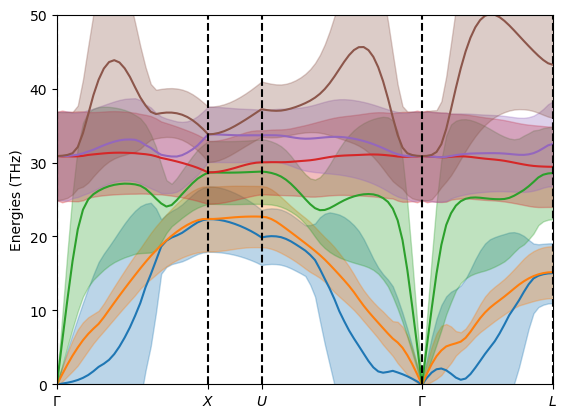

In [8]:
colors = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple", "tab:brown"]
plt.figure()

for ii, eng in enumerate(mean_energies.T):
    plt.fill_between(
        labels[0],
        eng - error_energies[:, ii],
        eng + error_energies[:, ii],
        color=colors[ii],
        alpha=0.3,
    )
    plt.plot(labels[0], eng, c=colors[ii])

for xcoord, name in zip(labels[1], labels[2]):
    plt.axvline(xcoord, c="k", ls="--")
plt.xticks(labels[1], labels[2])
plt.xlim(labels[1][[0, -1]])
plt.ylim(0, 50)
plt.ylabel("Energies (THz)")
plt.show()